In [13]:
import numpy as np
import numpy.linalg as LA
import math
import matplotlib.pyplot as plt
from matplotlib import rc
import scipy.stats as s_stats

from scipy.optimize import curve_fit
from scipy.optimize import brute
from scipy import asarray as ar,exp

import scipy.special as sp

from scipy.integrate import quad
from scipy.integrate import romberg

from tkinter import Tk
from tkinter import filedialog

#other methods to explore:
#bayesian blocks (variable bin widths), implemented in astropy
#kernel density estimation (implemented in scipy)

In [2]:
#return a bool indicating if a string can be represented numerically
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

In [3]:
#as an assessment of fit goodness, calculate the Bayesian Information Criterion (BIC)
#parameters are the Residual Sum of Squares RSS, number of model parameters k, and number of data points n
def calculate_BIC(RSS,k,n):
    return n*math.log(RSS/n)+k*math.log(n)

In [4]:
#read in the mobility values, defect angle, and bisection percentage
def readInFilesWithAngles():
    #read in the mobility file
    root = Tk()
    filename = filedialog.askopenfilename(title = "Choose the mobility file")
    #root.withdraw()
    f = open(filename,'r')
    #root.withdraw()

    mobList = []
    for line in f:
        newline = line.split()
        if is_number(newline[0][0]):
            mobList.append([float(newline[1])])  
     
    #read in the angle file
    filename = filedialog.askopenfilename(title = "Choose the angle file")
    g = open(filename,'r')
    root.withdraw()
    for counter, line in enumerate(g):
        newline = line.split()
        mobList[counter].append(float(newline[1]))
        mobList[counter].append(float(newline[2][1:-1]))
        
    return mobList

In [5]:
#read in the mobility values, defect angle, and bisection percentage
def readInFiles():
    #read in the mobility file
    root = Tk()
    filename = filedialog.askopenfilename(title = "Choose the mobility file")
    #root.withdraw()
    f = open(filename,'r')
    root.withdraw()

    mobList = []
    for line in f:
        newline = line.split()
        if is_number(newline[0][0]):
            mobList.append([float(newline[1])])  
            
    f.close()
        
    return mobList

In [41]:
def gausHistFit(resistanceList):
    mobilityList = [i[0] for i in resistanceList if i[0] > 0.0]
    mobilityArray = np.asarray(mobilityList)
    
    mean = np.mean(mobilityArray)
    sigma = np.std(mobilityArray)
    
    #plot the default data
    count, bins = np.histogram(mobilityList, 'fd')
    centers = [(i + bins[n])/2 for n, i in enumerate(bins[1:])]
    plt.hist(mobilityList,bins = len(centers), label = 'Data') #ec = 'black'
    
    def gaus(x,a,x0,sigma):
        return a*exp(-(x-x0)**2/(2*sigma**2))

    popt,pcov = curve_fit(gaus,centers,count,p0=[1,mean,sigma])

    #plt.plot(stored_centers,stored_hist,'b+:',label='data')
    plt.plot(centers,gaus(centers,*popt),'ko:',label='Gaussian Fit', alpha = 0.8)
    plt.legend()
    plt.ylabel("Count")
    plt.xlabel("Mobility [cm$^2$V$^{-1}$s$^{-1}$]")
    plt.show()
    
    print("Gaussian mean: ",popt[1])
    print("Gaussian σ: ",popt[2])

In [7]:
#Try to normalize the data logarithmically via a Box-Cox Normality Transform
#The transform is T(y)=(y^lambda-1)/lambda if lambda!=0, T(y)=log(y) if lambda=0
#The efficacy of the transform is assessed by measuring the normality of the resulting distribution
#This is done by using the scipy.stats.pearsonr method for measuring the pearson coefficient, on the
#corresponding normal probability plot

def applyBoxCoxTransform(resistanceList):
    mobilityList = [i[0] for i in resistanceList if i[0] > 0.0]
    
    #plot the default data
    count, bins = np.histogram(mobilityList, 'fd')
    centers = [(i + bins[n])/2 for n, i in enumerate(bins[1:])]
    plt.hist(mobilityList,bins = len(centers))
    plt.ylabel("Count")
    plt.xlabel("Mobility")
    plt.title('Raw Data')
    plt.show()
    
    
    cList = []
    _lambda = -0.5
    lambda_array = []
    lambdaMax = _lambda
    maxR = 0
    while _lambda < 5.0:
        if not np.isclose(_lambda, 0.0):
            T_of_mu = np.asarray([(i**_lambda-1)/_lambda for i in mobilityList])
        else:
            T_of_mu = np.asarray([math.log(i) for i in mobilityList])
        #n_bins = 60
        #use the freedman-diaconis rule to calculate number of bins
        #Under FD: h = 2*IQR*(n^(-1/3))
        hist, bins = np.histogram(T_of_mu, 'fd')
        centers = [(i + bins[n])/2 for n, i in enumerate(bins[1:])]

        #r_row, p_value = s_stats.pearsonr(hist, centers)

        #create the normal probability plot
        result = s_stats.probplot(T_of_mu)
        (osm,osr) = result[0]
        (slope,intercept,r) = result[1]

        r_row, p_values = s_stats.pearsonr(osm,osr)
        cList.append(r_row)

        if r_row > maxR:
            maxR = r_row
            lambdaMax = _lambda
            storedT = T_of_mu
            stored_hist = hist
            stored_centers = centers


        lambda_array.append(_lambda)
        _lambda += 0.01
    
    n_bins = len(stored_centers)
    #lambda_array = range(-1,1)
    plt.plot(lambda_array,cList)
    plt.xlabel("lambda")
    plt.ylabel("correlation coefficient")
    plt.title('Correlation Coefficient vs. Lambda')
    plt.show()
    
    print('Value of Lambda which maximized the correlation coefficient: %f'%lambdaMax)

    plt.hist(storedT,bins = n_bins)
    plt.ylabel("Count")
    plt.xlabel("Mobility")
    plt.title('Transformed Data')
    plt.show()

    mode_index = np.argmax(stored_hist)
    transformMode = stored_centers[mode_index]
    transformMean = np.mean(storedT)
    transformSigma = np.std(storedT)
    transformMedian = np.median(storedT)
    print("Transform mode is %f"%transformMode)
    print("Transform mean is %f"%transformMean)
    print("Transform median is %f"%transformMedian)

    normalMode = (lambdaMax*transformMode + 1)**(1/lambdaMax)
    normalMean = (lambdaMax*transformMean + 1)**(1/lambdaMax)
    normalMedian = (lambdaMax*transformMedian + 1)**(1/lambdaMax)
    print("Normal mode is %f"%normalMode)
    print("Normal mean is %f"%normalMean)
    print("Normal median is %f"%normalMedian)

    n = n_bins                                                 #the number of data points
    mean = sum(stored_hist*stored_centers)/n                   #note this correction
    sigma = sum(stored_hist*(stored_centers-mean)**2)/n        #note this correction

    def gaus(x,a,x0,sigma):
        return a*exp(-(x-x0)**2/(2*sigma**2))

    popt,pcov = curve_fit(gaus,stored_centers,stored_hist,p0=[1,transformMean,transformSigma])

    plt.plot(stored_centers,stored_hist,'b+:',label='data')
    plt.plot(stored_centers,gaus(stored_centers,*popt),'ro:',label='gaussian fit')
    plt.legend()
    plt.grid()
    plt.xlabel('Mobility')
    plt.ylabel('Count')
    plt.title('Gaussian Fit of Transformed Data')
    plt.show()

    gauss_max = stored_centers[np.argmax(gaus(stored_centers,*popt))]
    print(gauss_max)
    print((lambdaMax*gauss_max + 1)**(1/lambdaMax))

In [8]:
def lognormalDistFit(resistanceList):
    def lognormal(x,mu,sigma,beta):
        #mu is the mean of ln(x)
        #sigma is the std of ln(x)
        #beta scales the distribution's size
        #x0 centers the distribution
        #return 1/((x-x0)*sigma*math.sqrt(2*math.pi))*exp(-((np.log(x-x0)-mu)**2)/(2*sigma**2))*beta
        return 1/((x)*sigma*math.sqrt(2*math.pi))*exp(-((np.log(x)-mu)**2)/(2*sigma**2))*beta
    
    mobilityList = np.asarray([i[0] for i in resistanceList if i[0] > 0.0])
    mean = np.mean(mobilityList)
    
    #n_bins = 60
    #use the freedman-diaconis rule to calculate number of bins
    #Under FD: h = 2*IQR*(n^(-1/3))
    count, bins = np.histogram(mobilityList, 'fd')
    centers = [(i + bins[n])/2 for n, i in enumerate(bins[1:])]
    
    #normalize the count:
    countTotal = sum(count)
    normal_count = np.true_divide(count,countTotal)
    #normal_count = count
    
    popt,pcov = curve_fit(lognormal,np.asarray(centers),normal_count,p0=[1,1,1])
    mu = popt[0]
    sigma = popt[1]

    plt.plot(centers,countTotal*normal_count,'b+:',label='data')
    plt.plot(centers,countTotal*lognormal(np.asarray(centers),*popt),'ro:',label='fit')
    plt.title('LogNormal Distribution')
    plt.legend()
    plt.grid()
    plt.show()
    
    mean = math.exp(mu+0.5*sigma**2)
    median = math.exp(mu)
    mode = math.exp(mu-sigma**2)
    variance = (math.exp(sigma**2)-1)*math.exp(2*mu+sigma**2)
    skewness = (math.exp(sigma**2)+2)*math.sqrt(exp(sigma**2)-1)
    print('Mean is: %f'%mean)
    print('Median is: %f'%median)
    print('Mode is: %f'%mode)
    print('Variance is: %f'%variance)
    print('Skewness is: %f'%skewness)
    print('mu is: %f'%mu)
    print('Sigma is: %f'%sigma)
    
    n = len(centers)
    k = 3
    difArray= countTotal*normal_count - countTotal*lognormal(np.asarray(centers),*popt)
    RSS = np.sum(difArray**2)
    BIC = calculate_BIC(RSS,k,n)
    print('BIC is: %f'%BIC)

In [9]:
def weibullFit(resistanceList):
    def weibull(x,lam,k,beta):
        #lam=lambda is the scale parameter
        #k>0 is the shape parameter
        #mu is the location offset
        #beta scales the distribution's size
        return k/lam*(((x)/lam)**(k-1))*exp(-(((x)/lam)**k))/beta
    
    mobilityList = np.asarray([i[0] for i in resistanceList if i[0] > 0.0])
    mean = np.mean(mobilityList)
    
    #n_bins = 60 
    #use the Freedman-Diaconis Rule to calculate the number of bins in the histogram
    #Under FD: h = 2*IQR*(n^(-1/3))
    count, bins = np.histogram(mobilityList, 'fd')
    centers = [(i + bins[n])/2 for n, i in enumerate(bins[1:])]
    
    #normalize the count:
    countTotal = sum(count)
    normal_count = np.true_divide(count,countTotal)
    #normal_count = count
    
    popt,pcov = curve_fit(weibull,centers,normal_count,p0=[2,1,1])

    plt.plot(centers,countTotal*normal_count,'b+:',label='data')
    plt.plot(centers,countTotal*weibull(centers,*popt),'ro:',label='fit')
    plt.title('Weibull Distribution')
    plt.legend()
    plt.grid()
    plt.show()
    
    lam = popt[0]
    k = popt[1]
    
    mean = lam*sp.gamma(1+1/k)
    median = lam*(math.log(2))**(1/k)
    mode = lam*((k-1)/k)**(1/k)
    variance = (lam**2)*(sp.gamma(1+2/k)-(sp.gamma(1+1/k))**2)
    std = math.sqrt(variance)
    skewness = (sp.gamma(1+3/k)*lam**3-3*mean*std**2 - mean**3)/std**3
    
    print('Mean is: %f'%mean)
    print('Median is: %f'%median)
    print('Mode is: %f'%mode)
    print('Variance is: %f'%variance)
    print('Skewness is: %f'%skewness)
    print('Lambda is: %f'%lam)
    print('k is: %f'%k)
    
    #n = n_bins
    n = len(centers)
    k = 3
    difArray= countTotal*normal_count - countTotal*weibull(np.asarray(centers),*popt)
    RSS = np.sum(difArray**2)
    BIC = calculate_BIC(RSS,k,n)
    print('BIC is: %f'%BIC)

In [10]:
def chiSquareDistFit(resistanceList):
    def chiSquare(x,nu,beta):
        #print(nu, beta, mu)
        return beta*exp(-(x)/2)*((x)**(nu/2 - 1))/((2**(nu/2))*sp.gamma(nu/2))
    
    mobilityList = np.asarray([i[0] for i in resistanceList if i[0] > 0.0])
    
    #n_bins = 60
    #use the freedman-diaconis rule to calculate number of bins
    #Under FD: h = 2*IQR*(n^(-1/3))
    count, bins = np.histogram(mobilityList, 'fd')
    centers = np.asarray([(i + bins[n])/2 for n, i in enumerate(bins[1:])])
    
    #normalize the count:
    countTotal = sum(count)
    normal_count = np.true_divide(count,countTotal)
    
    
    popt,pcov = curve_fit(chiSquare,centers,normal_count,p0=[5,1])

    plt.plot(centers,countTotal*normal_count,'b+:',label='data')
    plt.plot(centers,countTotal*chiSquare(centers,*popt),'ro:',label='fit')
    plt.title('Chi-Square Distribution')
    plt.legend()
    plt.grid()
    plt.show()
    
    n = len(centers)
    k = 2
    difArray= countTotal*normal_count - countTotal*chiSquare(np.asarray(centers),*popt)
    RSS = np.sum(difArray**2)
    BIC = calculate_BIC(RSS,k,n)
    print('BIC is: %f'%BIC)

In [11]:
def gammaDistFit(resistanceList):
    #gamma distribution with a location offset and scaling factor scale
    def gammaDist(x,g,beta,scale):
        return scale*(((x))**(g-1))*1/exp((x)/beta)/((beta**g)*sp.gamma(g))
    
    mobilityList = np.asarray([i[0] for i in resistanceList if i[0] > 0.0])
    
    #n_bins = 60
    #use the freedman-diaconis rule to calculate number of bins
    #Under FD: h = 2*IQR*(n^(-1/3))
    count, bins = np.histogram(mobilityList, 'fd')
    centers = [(i + bins[n])/2 for n, i in enumerate(bins[1:])]
    
    #normalize the count:
    countTotal = sum(count)
    normal_count = np.true_divide(count,countTotal)
    
    mean = np.mean(mobilityList)
    
    popt,pcov = curve_fit(gammaDist,centers,normal_count,p0=[2,1,1])

    g = popt[0]
    beta = popt[1]
    #muIndex = popt[2]
    scale = popt[2]
    
    
    mean = g*beta
    mode = (g-1)*beta
    variance = g*(beta)**2
    std = math.sqrt(variance)
    skewness = 2/math.sqrt(g)
    
    print('Mean is: %f'%mean)
    print('Mode is: %f'%mode)
    print('Variance is: %f'%variance)
    print('Skewness is: %f'%skewness)
    print('g is: %f'%g)
    print('beta is: %f'%beta)
    
    
    plt.plot(centers,countTotal*normal_count,'b+:',label='data')
    plt.plot(centers,countTotal*gammaDist(centers,*popt),'ro:',label='fit')
    plt.title('Gamma Distribution')
    plt.legend()
    plt.grid()
    plt.show()
    
    n = len(centers)
    k = 3
    difArray= countTotal*normal_count - countTotal*gammaDist(np.asarray(centers),*popt)
    RSS = np.sum(difArray**2)
    BIC = calculate_BIC(RSS,k,n)
    print('BIC is: %f'%BIC)

In [12]:
def erlangDistFit(resistanceList):
    #erlang distribution
    def erlangDist(x,k,lam,scale):
        return (lam**k)*((x)**(k-1))*exp(-lam*(x))/(scale*math.factorial(int(k)-1))
    
    mobilityList = np.asarray([i[0] for i in resistanceList if i[0] > 0.0])
    
    #n_bins = 60
    #use the freedman-diaconis rule to calculate number of bins
    #Under FD: h = 2*IQR*(n^(-1/3))
    count, bins = np.histogram(mobilityList, 'fd')
    centers = np.asarray([(i + bins[n])/2 for n, i in enumerate(bins[1:])])
    
    #normalize the count:
    countTotal = sum(count)
    normal_count = np.true_divide(count,countTotal)
    
    mean = np.mean(mobilityList)
    
    def lambdaAndScale(k, xs, ys):
        def erlang(xs, lam,scale):
            return (lam**k)*((xs)**(k-1))*exp(-lam*(xs))/(math.factorial(k-1)*scale)
        popt, pcov = curve_fit(erlang, xs, ys)
        errsqr = np.linalg.norm(erlang(xs, *popt) - ys)
        return dict(errsqr=errsqr, floatcoef=popt)
    
    def errfun(k, *args):
        xs, ys = args
        return lambdaAndScale(k, xs, ys)['errsqr']

    grid = [slice(2, 9, 1)]  # grid search over 1, 2, ..., 9
    # it is important to specify finish=None in below
    k = brute(errfun, grid, args=(centers, normal_count,), finish=None)
    float_parameters = lambdaAndScale(k, centers, normal_count)['floatcoef']
    _lambda = float_parameters[0]
    scale = float_parameters[1]
    
    mean = k/_lambda
    mode = 1/_lambda*(k-1)
    variance = k/(_lambda**2)
    std = math.sqrt(variance)
    skewness = 2/math.sqrt(k)
    
    print('Mean is: %f'%mean)
    print('Mode is: %f'%mode)
    print('Variance is: %f'%variance)
    print('Skewness is: %f'%skewness)
    print('k is: %i'%k)
    print('lambda is: %f'%_lambda)
    
    plt.plot(centers,countTotal*normal_count,'b+:',label='data')
    plt.plot(np.asarray(centers),countTotal*erlangDist(np.asarray(centers),k,*float_parameters),'ro:',label='fit')
    plt.title('Erlang Distribution')
    plt.legend()
    plt.grid()
    plt.show()
    
    n = len(centers)
    k_bic = 3
    difArray= countTotal*normal_count - countTotal*erlangDist(np.asarray(centers),k,*float_parameters)
    RSS = np.sum(difArray**2)
    BIC = calculate_BIC(RSS,k_bic,n)
    print('BIC is: %f'%BIC)

In [13]:
def kernelDensityEstimate(resistanceList):
    from scipy.stats import gaussian_kde
    def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
        """Kernel Density Estimation with Scipy"""
        # Note that scipy weights its bandwidth by the covariance of the
        # input data.  To make the results comparable to the other methods,
        # we divide the bandwidth by the sample standard deviation here.
        kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
        return kde.evaluate(x_grid)
    
    mobilityList = np.asarray([i[0] for i in resistanceList if i[0] > 0.0])
    maxMobility = max(mobilityList)
    minMobility = min(mobilityList)
    mobility_grid = np.linspace(minMobility,maxMobility,1000)
    
    kernel_data = kde_scipy(mobilityList,mobility_grid,bandwidth = 0.2)
    plt.plot(mobility_grid,kernel_data)
    plt.xlabel("Mobility ($cm^{2}/Vs$)")
    plt.ylabel("Kernel Density Estimate")
    plt.title("Gaussian Kernel Density Estimation")
    plt.savefig('KDE.png', format='png', dpi=1200)
    plt.show()
    
    y_array = np.asarray(kernel_data)
    maxIndice = np.argmax(y_array)
    mode = mobility_grid[maxIndice]
    
    product_array = np.multiply(mobility_grid, y_array)
    y_sum = np.sum(y_array)
    prod_sum = np.sum(product_array)
    mean = prod_sum/y_sum
    
    stdArray = np.asarray([(i - mean)**2 for i in mobility_grid])
    stdArray = np.multiply(y_array, stdArray)
    N = np.sum(y_array)
    std = math.sqrt(np.sum(stdArray)/(N-1))
    #std = math.sqrt(stdArray/(len(stdArray)-1))
        
    std_mob = mobilityList.std()
    std_mean = mobilityList.mean()
    print(std_mob)
    print(mean)
    print(std)
    print(std_mean)
    
    print("Mode is: %f $cm^{2}/Vs$"%mode)
    print("Mean is: %f +- %f"%(std_mean, std_mob))
    

In [14]:
def mobilityVsAngleRaw(resistanceList):
    mobilities = np.asarray([i[0] for i in resistanceList])
    angles = np.asarray([i[1] for i in resistanceList])
    colors = np.random.rand(len(angles))
    
    plt.scatter(angles,mobilities,c = colors,alpha = 0.5)
    plt.xlabel("Boundary Angle Counterclockwise (degrees)")
    plt.ylabel("Mobility ($cm^{2}/Vs$)")
    plt.savefig('mobility_vs_angle.png', format='png', dpi=1200)
    plt.show()
    
    minAngle = np.min(angles)
    maxAngle = np.max(angles)
    stepSize = (maxAngle-minAngle)/10
    meanList = []
    stdList = []
    
    angleArray = np.arange(minAngle,maxAngle,step=stepSize)
    
    for j in angleArray:
        currArray = np.asarray([i[0] for i in resistanceList if i[1] >= j and i[1] < j + stepSize])
        meanList.append(currArray.mean())
        stdList.append(currArray.std())
        
    plt.bar(np.add(angleArray,stepSize/2), np.asarray(meanList), width = 0.8*stepSize, color='c', yerr=np.asarray(stdList), capsize = 0.1*stepSize)
    plt.xlabel("Angle")
    plt.ylabel("Mobility ($cm^{2}/Vs$)")
    plt.show()

In [144]:
def multiGausFit(undefectedList, grainList, twinList):
    def gaus(x,a,x0,sigma):
        return a*exp(-(x-x0)**2/(2*sigma**2))
    
    mobilityCutoff = 0.0
    
    undefectedArray = np.asarray([i[0] for i in undefectedList if i[0] > mobilityCutoff])
    grainArray = np.asarray([i[0] for i in grainList if i[0] > mobilityCutoff])
    twinArray = np.asarray([i[0] for i in twinList if i[0] > mobilityCutoff])
    
    meanUndefected = np.mean(undefectedArray)
    sigmaUndefected = np.std(undefectedArray)
    
    meanGrain = np.mean(grainArray)
    sigmaGrain = np.std(grainArray)
    
    meanTwin = np.mean(twinArray)
    sigmaTwin = np.std(twinArray)
    
#     fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex = True)
    
#     #plot the undefected data
#     count, bins = np.histogram(undefectedArray, 'fd')
#     centers = [(i + bins[n])/2 for n, i in enumerate(bins[1:])]
#     ax1.hist(undefectedArray,bins = len(centers), label = 'Data', color = 'steelblue') #ec = 'black'
#     popt,pcov = curve_fit(gaus,centers,count,p0=[1,meanUndefected,sigmaUndefected])
#     ax1.plot(centers,gaus(centers,*popt),'ko:',alpha = 0.8)
#     ax1.set_ylabel("Count")
#     #ax1.set_xlabel("Mobility [cm$^2$V$^{-1}$s$^{-1}$]")
#     print("Gaussian mean undefected: ",popt[1])
#     print("Gaussian σ undefected: ",popt[2])
    
#     #plot the grain data
#     count, bins = np.histogram(grainArray, 'fd')
#     centers = [(i + bins[n])/2 for n, i in enumerate(bins[1:])]
#     ax2.hist(grainArray,bins = len(centers), label = 'Data', color = 'darkgreen') #ec = 'black'
#     popt,pcov = curve_fit(gaus,centers,count,p0=[1,meanGrain,sigmaGrain])
#     ax2.plot(centers,gaus(centers,*popt),'ko:',alpha = 0.8)
#     #ax2.set_xlabel("Mobility [cm$^2$V$^{-1}$s$^{-1}$]")
#     ax2.set_ylabel("Count")
#     print("Gaussian mean grains: ",popt[1])
#     print("Gaussian σ grains: ",popt[2])
    
#     #plot the twin data
#     count, bins = np.histogram(twinArray, 'fd')
#     centers = [(i + bins[n])/2 for n, i in enumerate(bins[1:])]
#     ax3.hist(twinArray,bins = len(centers), label = 'Data', color = 'darkred') #ec = 'black'
#     popt,pcov = curve_fit(gaus,centers,count,p0=[1,meanTwin,sigmaTwin])
#     ax3.plot(centers,gaus(centers,*popt),'ko:',label='Gaussian Fit', alpha = 0.8)
#     ax3.set_ylabel("Count")
#     print("Gaussian mean twins: ",popt[1])
#     print("Gaussian σ twins: ",popt[2])
    
#     ax3.set_xlabel("Mobility [cm$^2$V$^{-1}$s$^{-1}$]")
#     #plt.tight_layout()
#     fig.legend(loc='upper right', bbox_to_anchor=(0.95, 0.5))
#     fig.savefig('TriDensMobilityFigure.png', format='png', dpi=1200)
#     plt.show()
    
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex = True, figsize = (6,12))
    #fig = plt.figure(figsize = (6,12),sharex = True)
    fig.subplots_adjust(top = 0.98, bottom = 0.04, right = 0.98, hspace=0.1)
    plt.rcParams["font.family"] = 'sans-serif'
    #plt.rc('font', family='serif')
    #rc('font',**{'family':'serif','serif':['Computer Modern']})
#     rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
#     rc('text', usetex=True)
    #fig.rcParams["font.family"] = "Times New Roman"
    
    #plot the undefected data
    #ax1 = fig.add_subplot(3,1,1)
    #ax1.set_title("Undefected SLs Mobility Values", fontsize = 14)
    count, bins = np.histogram(undefectedArray, 'fd')
    centers = [(i + bins[n])/2 for n, i in enumerate(bins[1:])]
    ax1.hist(undefectedArray,bins = len(centers), color = 'steelblue', label = 'Undefected SLs', ec = 'black')
    popt,pcov = curve_fit(gaus,centers,count,p0=[1,meanUndefected,sigmaUndefected])
    #ax1.plot(centers,gaus(centers,*popt),'ko:',label = 'Gaussian Fit', alpha = 0.8)
    ax1.set_ylabel("Count", fontsize = 12)
    #ax1.set_xlabel("Mobility [cm$^2$V$^{-1}$s$^{-1}$]", fontsize = 12)
    ax1.legend(loc = 'upper right', fontsize = 12)
    ax1.set_ylim([0,350])
    textString = r'$\bar \mu$ = {0:.2f}'.format(popt[1]) + "\n" + "$\sigma$ = {0:.2f}".format(popt[2])
    ax1.text(0.69,200,textString,style = 'italic',fontsize = 12,bbox = {'facecolor':'white','pad':10})
    ax1.text(0.01,325, "(a)", fontsize = 16)
    ax1.set_xlim([0,0.9])
    
    #plot the grain boundary data
    #ax2 = fig.add_subplot(3,1,2)
    #ax2.set_title("Twin Plane SLs Mobility Values",fontsize = 14)
    count, bins = np.histogram(twinArray, 'fd')
    centers = [(i + bins[n])/2 for n, i in enumerate(bins[1:])]
    ax2.hist(twinArray,bins = len(centers), color = 'tab:orange', label = 'Twin Plane SLs', ec = 'black')
    popt,pcov = curve_fit(gaus,centers,count,p0=[1,meanTwin,sigmaTwin])
    #ax2.plot(centers,gaus(centers,*popt),'ko:', label = 'Gaussian Fit',alpha = 0.8)
    ax2.set_ylabel("Count", fontsize = 12)
    #ax2.set_xlabel("Mobility [cm$^2$V$^{-1}$s$^{-1}$]", fontsize = 12)
    ax2.set_ylim([0,350])
    ax2.legend(loc = 'upper right', fontsize = 12)
    textString = r'$\bar \mu$ = {0:.2f}'.format(popt[1]) + "\n" + "$\sigma$ = {0:.2f}".format(popt[2])
    ax2.text(0.69,200,textString,style = 'italic',fontsize = 12,bbox = {'facecolor':'white','pad':10})
    ax2.text(0.01,325, "(b)", fontsize = 16)
    ax2.set_xlim([0,0.85])
    
    #plot the twin plane data
    #ax3 = fig.add_subplot(3,1,3)
    #ax3.set_title("Grain Boundary SLs Mobility Values",fontsize = 14)
    count, bins = np.histogram(grainArray, 'fd')
    centers = [(i + bins[n])/2 for n, i in enumerate(bins[1:])]
    ax3.hist(grainArray,bins = len(centers), color = 'firebrick', label = 'Grain Boundary SLs', ec = 'black')
    popt,pcov = curve_fit(gaus,centers,count,p0=[1,meanGrain,sigmaGrain])
    #ax3.plot(centers,gaus(centers,*popt),'ko:',label = 'Gaussian Fit',alpha = 0.8)
    ax3.set_ylabel("Count", fontsize = 12)
    ax3.set_xlabel("Mobility [cm$^2$V$^{-1}$s$^{-1}$]", fontsize = 12)
    ax3.set_ylim([0,350])
    ax3.legend(loc = 'upper right', fontsize = 12)
    textString = r'$\bar \mu$ = {0:.2f}'.format(popt[1]) + "\n" + "$\sigma$ = {0:.2f}".format(popt[2])
    ax3.text(0.69,200,textString,style = 'italic',fontsize = 12,bbox = {'facecolor':'white','pad':10})
    ax3.text(0.01,325, "(c)", fontsize = 16)
    ax3.set_xlim([0,0.9])
    
    fig.savefig('TriDensMobilityFigure.png', format='png', dpi=300)
    plt.show()
    
    fig, (ax1, ax2) = plt.subplots(2,1, sharex = True, figsize = (6,8))
    fig.subplots_adjust(hspace = 0.1, top = 0.98, bottom = 0.04, right = 0.98)
    #fig = plt.figure(figsize = (6,8))
    #fig.subplots_adjust(top = 0.98, bottom = 0.04, right = 0.96, hspace=0.30)
    #ax1 = fig.add_subplot(2,1,1)
    ax1.hist(undefectedArray,bins = 'fd', color = 'steelblue',alpha = 0.51, label = "Undefected SLs", ec = 'black')
    ax1.hist(twinArray,bins = 'fd', color = 'tab:orange', alpha = 0.51, label = "Twin Plane SLs", ec = 'black')
    ax1.legend(loc = 'upper right')
    ax1.set_ylabel("Count", fontsize = 12)
    ax1.set_ylim([0,350])
    ax1.set_xlim([0,0.85])
    
    #fig.subplots_adjust(top = 0.98, bottom = 0.04, right = 0.96, hspace=0.30)
    #ax2 = fig.add_subplot(2,1,2)
    ax2.hist(undefectedArray,bins = 'fd', color = 'steelblue',alpha = 0.51, label = "Undefected SLs", ec = 'black')
    ax2.hist(grainArray,bins = 'fd', color = 'firebrick', alpha = 0.51, label = "Grain Boundary SLs", ec = 'black')
    ax2.set_ylim([0,350])
    ax2.set_ylabel("Count", fontsize = 12)
    ax2.set_xlabel("Mobility [cm$^2$V$^{-1}$s$^{-1}$]", fontsize = 12)
    ax2.legend(loc = 'upper right')
    ax2.set_xlim([0,0.85])
    plt.show()
    
#     count, bins = np.histogram(undefectedArray, 'fd')
#     centers = [(i + bins[n])/2 for n, i in enumerate(bins[1:])]
#     popt,pcov = curve_fit(gaus,centers,count,p0=[1,meanUndefected,sigmaUndefected])
#     plt.plot(centers,gaus(centers,*popt),'-.',color = 'steelblue', label = 'Undefected Data')
#     plt.fill_between(centers, gaus(centers,*popt),color = 'steelblue', alpha = 0.51)
    
#     count, bins = np.histogram(twinArray, 'fd')
#     centers = [(i + bins[n])/2 for n, i in enumerate(bins[1:])]
#     popt,pcov = curve_fit(gaus,centers,count,p0=[1,meanTwin,sigmaTwin])
#     plt.plot(centers,gaus(centers,*popt),'--',color = 'tab:orange', label = 'Twin Data')
#     plt.fill_between(centers, gaus(centers,*popt),color = 'tab:orange', alpha = 0.51)
    
#     count, bins = np.histogram(grainArray, 'fd')
#     centers = [(i + bins[n])/2 for n, i in enumerate(bins[1:])]
#     popt,pcov = curve_fit(gaus,centers,count,p0=[1,meanGrain,sigmaGrain])
#     plt.plot(centers,gaus(centers,*popt),'.',color = 'darkgreen', label = 'Grain Data')
#     plt.fill_between(centers, gaus(centers,*popt),color = 'darkgreen', alpha = 0.51)
#     plt.legend(loc = 'upper right')
#     plt.show()
    
    
    
    #bar plot with multiple entries. Not great because bins are different for the three data sets
#     plt.hist([undefectedArray, grainArray, twinArray],bins = 'fd', label = ['Undefected', 'Grains', 'Twins'], color = ['steelblue', 'darkgreen', 'darkred'])
#     plt.legend(loc = 'upper right')
#     plt.show()
    

In [15]:
# for i in mobilityList:
#     if i[0] > 2.0:
#         print("Mobility: {} Angle: {}".format(i[0], i[1]))

In [57]:
mobilityList = readInFiles()
#mobilityList = readInFilesWithAngles()

In [7]:
undefectedList = readInFiles()
grainList = readInFiles()
twinList = readInFiles()

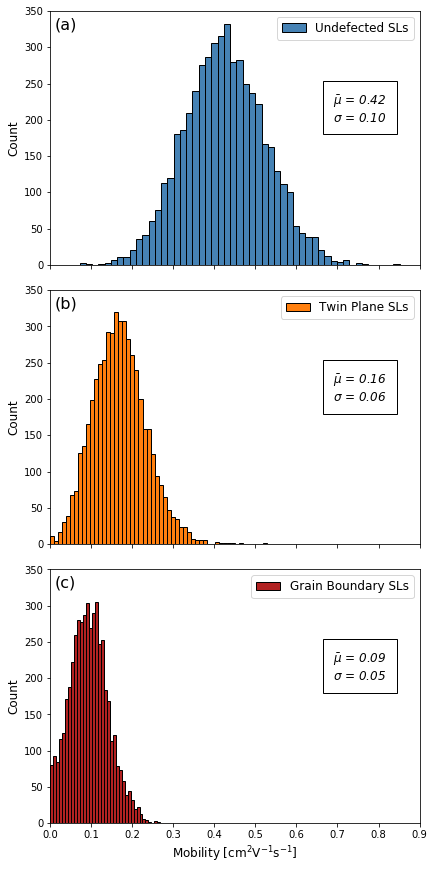

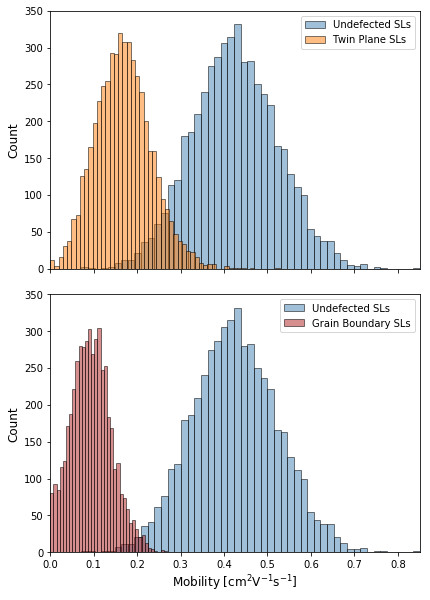

In [145]:
multiGausFit(undefectedList, grainList, twinList)

In [17]:
#bisectedList = [i for i in mobilityList if np.isclose(i[2],1)]
#bisectedNonPerfect = [i for i in bisectedList if not np.isclose(i[1],9)]
#bisectedPerfect = [i for i in bisectedList if np.isclose(i[1],9)]
#nonBisectedList = [i for i in mobilityList if i[2] < 1]
#bisected

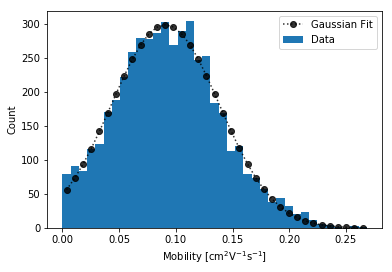

Gaussian mean:  0.0907568606968
Gaussian σ:  0.0476714159505


In [58]:
gausHistFit(mobilityList)

In [ ]:
applyBoxCoxTransform(mobilityList)

In [ ]:
lognormalDistFit(nonBisectedList)

In [ ]:
chiSquareDistFit(nonBisectedList)

In [ ]:
weibullFit(nonBisectedList)

In [ ]:
gammaDistFit(nonBisectedList)

In [ ]:
erlangDistFit(nonBisectedList)

In [ ]:
kernelDensityEstimate(mobilityList)

In [ ]:
mobilityVsAngleRaw(mobilityList)

In [146]:
text = r'$\bar T$'
print(text)

$\bar T$


In [195]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [12]:
import matplotlib.font_manager as mpltfm
print(mpltfm.get_cachedir())

C:\Users\Davis\.matplotlib
